#%% [markdown]
# MNIST_FPGA

<img src="img/MNIST.jpg">

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

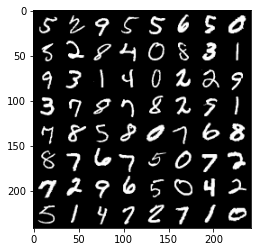

In [2]:
#使用pytorch自带MNIST数据集
#设置数据预处理(可以添加标准化)
transform = torchvision.transforms.ToTensor()
train_data = torchvision.datasets.MNIST(root="./data/",                                 #数据目录，这里目录结构要注意。
                                        train=True,                                     #是否为训练集
                                        transform=transform,                            #加载数据预处理
                                        download=True )                                 #是否下载，这里下载偏慢
test_data = torchvision.datasets.MNIST(root="./data/",
                                        train=False,
                                        transform=transform,
                                        download=True )
train_loader = torch.utils.data.DataLoader(dataset = train_data,batch_size = 64,shuffle = True) #数据加载器:组合数据集和采样器
test_loader = torch.utils.data.DataLoader(dataset = test_data,batch_size = 64,shuffle = False)
# 展示数据
def imshow(img):
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show
imshow(torchvision.utils.make_grid(iter(train_loader).next()[0]))


#%% [markdown]
<font color=blue size=10>全连接网络（BP）</font>


In [3]:
# class BP_net(nn.Module):
#     '''
#     BP
#     '''
#     def __init__(self):
#         super(BP_net,self).__init__()
#         # 隐含层
#         self.fc1=nn.Sequential(nn.Linear(784,200),nn.ReLU())
#         self.fc2=nn.Sequential(nn.Linear(200,100),nn.ReLU())
#         self.fc3=nn.Sequential(nn.Linear(100,20),nn.ReLU())
#         # 输出层
#         self.fc4=nn.Linear(20,10)
#     def forward(self,x):
#         x=self.fc1(x)
#         x=self.fc2(x)
#         x=self.fc3(x)
#         x=self.fc4(x)
#         return x

In [4]:
class LeNet(nn.Module): #定义网络 
    '''
    LeNet
    '''
    def __init__(self):
        super(LeNet,self).__init__()
        self.conv1 = nn.Sequential(     #input_size=(1*28*28)
            nn.Conv2d(1,6,5,1,2),       #padding=2，图片大小变为 28+2*2 = 32 (两边各加2列0)，保证输入输出尺寸相同
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2 ,stride = 2)   #input_size=(6*28*28)，output_size=(6*14*14)
        )
 
        self.conv2 = nn.Sequential(
            nn.Conv2d(6,16,5),                          #input_size=(6*14*14)，output_size=16*10*10
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,stride = 2)    ##input_size=(16*10*10)，output_size=(16*5*5)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 120, 5),  # input_size=(16*5*5)，output_size=120*1*1
            nn.ReLU(),
        )
        # self.fc1 = nn.Sequential(
        #     nn.Linear(16*5*5,120),
        #     nn.ReLU()
        # )
 
        self.fc2 = nn.Sequential(
            nn.Linear(120,84),
            nn.ReLU()
        )
 
        self.fc3 = nn.Linear(84,10)
 
    #网络前向传播过程
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1) #全连接层均使用的nn.Linear()线性结构，输入输出维度均为一维，故需要把数据拉为一维
        # x = self.fc1(x)

        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [5]:
# 定义是否使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:",device)
net=LeNet().to(device) 
#定义优化器
optimizer = optim.Adam(net.parameters(),lr = 0.001)
# 定义损失函数
loss_fuc = nn.CrossEntropyLoss()    #多分类问题，选择交叉熵损失函数

device: cuda


In [6]:
#Star train
EPOCH = 30   #训练总轮数
# net.load_state_dict(torch.load('Lenet.pth'))
for epoch in range(EPOCH):
    sum_loss = 0
    # 数据读取
    for i,data in enumerate(train_loader):
        inputs,labels = data
        inputs, labels = inputs.to(device), labels.to(device)   #有GPU则将数据置入GPU加速
        # 梯度清零
        optimizer.zero_grad()

        # 传递损失 + 更新参数
        output = net(inputs)
        loss = loss_fuc(output,labels)
        loss.backward()
        optimizer.step()

        # 每训练100个batch打印一次平均loss
        sum_loss += loss.item()
        if i % 100 == 99:
            print('[Epoch:%d, batch:%d] train loss: %.05f' % (epoch + 1, i + 1, sum_loss / 100))
            sum_loss = 0.0
 
    correct = 0
    total = 0
 
    for data in test_loader:
        test_inputs, labels = data
        test_inputs, labels = test_inputs.to(device), labels.to(device)
        outputs_test = net(test_inputs)
        _, predicted = torch.max(outputs_test.data, 1)  #输出得分最高的类
        total += labels.size(0) #统计50个batch 图片的总个数
        correct += (predicted == labels).sum()  #统计50个batch 正确分类的个数
 
    print('第%d个epoch的识别准确率为：%d%%' % (epoch + 1, (100 * correct / total)))

[Epoch:1, batch:100] train loss: 1.22698
[Epoch:1, batch:200] train loss: 0.42358
[Epoch:1, batch:300] train loss: 0.31017
[Epoch:1, batch:400] train loss: 0.24796
[Epoch:1, batch:500] train loss: 0.19132
[Epoch:1, batch:600] train loss: 0.18322
[Epoch:1, batch:700] train loss: 0.15015
[Epoch:1, batch:800] train loss: 0.12607
[Epoch:1, batch:900] train loss: 0.13465
第1个epoch的识别准确率为：97%
[Epoch:2, batch:100] train loss: 0.10645
[Epoch:2, batch:200] train loss: 0.10452
[Epoch:2, batch:300] train loss: 0.09520
[Epoch:2, batch:400] train loss: 0.08523
[Epoch:2, batch:500] train loss: 0.09323
[Epoch:2, batch:600] train loss: 0.08491
[Epoch:2, batch:700] train loss: 0.07373
[Epoch:2, batch:800] train loss: 0.07152
[Epoch:2, batch:900] train loss: 0.07264
第2个epoch的识别准确率为：98%
[Epoch:3, batch:100] train loss: 0.05968
[Epoch:3, batch:200] train loss: 0.06694
[Epoch:3, batch:300] train loss: 0.06854
[Epoch:3, batch:400] train loss: 0.05774
[Epoch:3, batch:500] train loss: 0.06436
[Epoch:3, batch:6

In [7]:
#将训练的权重进行保存
save_path = './Lenet.pth'
torch.save(net.state_dict(), save_path)